##### Mintos analysis
After downloading loans for primary and secondary markets, scraping and cleaning data for originator groups and originators, and joining all datasets I ended up with a 231 Mb dataframe. 

Here I will show preliminary analysis on factors driving loan interest rates

In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import joblib
import seaborn as sb
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [2]:
df = joblib.load('all_loans.df')

In [3]:
df1 = df[(df['Market']=='Primary') & (df['Buyback Guarantee']=='Yes') & (df['Currency']=='EUR')]

In [9]:
columns  = ['Amortization Method', 'Borrower APR', 'Country', 'LTV' , 'Loan Type', 'Payments Received', 'Status', 'loan_days_remaining', \
            'loan_days_elapsed', 'originator_page_updated_days_ago','group_year_founded', 'group_loans_on_mintos', \
            'group_joined_mintos_days_ago', 'group_schedule_extension', 'originator_mintos_rating', \
            'originator_founded', 'originator_loans_originated', 'originator_skin', 'originator_investment_structure', \
            'originator_pledge_of_assets', 'originator_group_guarantee', 'originator_interest_income', 'originator_interest_income_delayed_payments', \
            'originator_penalty_income', 'originator_grace_period', 'originator_default_interest', 'originator_ammortization_type'
           ]

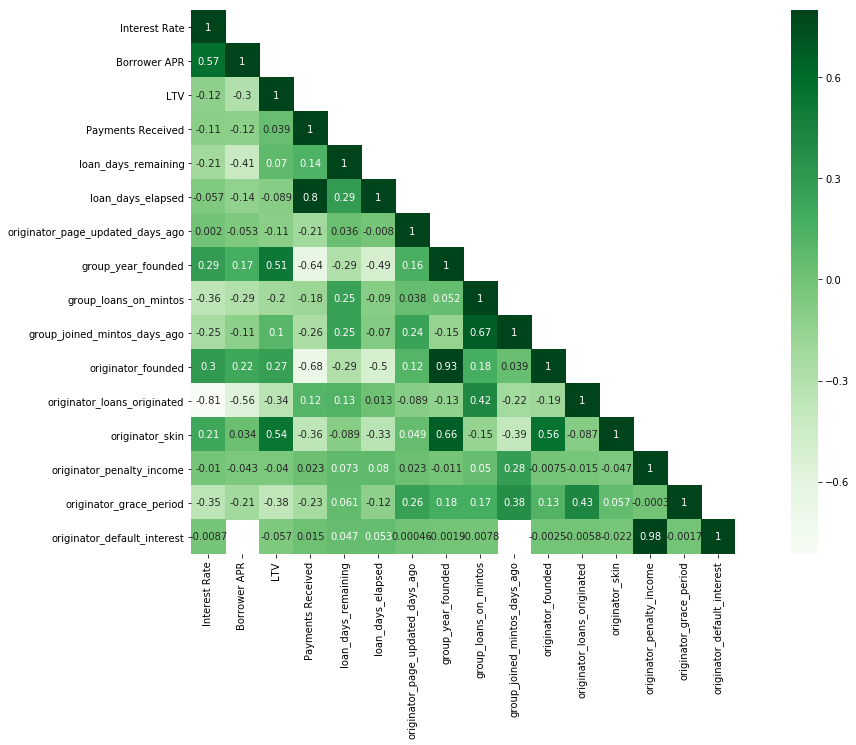

In [10]:
corrMatt = df1[['Interest Rate'] + columns].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sb.heatmap(corrMatt, cmap="Greens", mask=mask,vmax=.8, square=True,annot=True)

Not surprisingly, (numerical) features related to "quality" of originator group, or originator are largest (linear) correlates to interest rate.

Highest (in absolute sense) linear factor is the total amount loaned through originator, negatively correlated to the interst rate. This is of course an obvious connection - the larger and more active is the originator, the longer they have been in lending, the lower is the credit risk, the lower is the interest rate. Other originator-related factors are total amount loand through originator group, how long originator been with Mintos, and when originator company was founded. 

One borrower-specific factor with strong linear correlation is borrower APR, but this is a clear case of correlation not causation. 

Linear correlation is of course quite limiting in analysis of factors and potential modelling features. For more flexible approach I explore model-based feature importance.

In [12]:
X = pd.concat(   [ df1['Amortization Method'].cat.codes , # 0
                     df1['Borrower APR'],   # 1
                     df1['Country'].cat.codes,  # 2
                     df1['LTV'], # 3
                     df1['Loan Type'].cat.codes,  # 4
                     df1['Payments Received'], # 5
                     df1['Status'].cat.codes, # 6
                     df1.loan_days_remaining,
                     df1.loan_days_elapsed,
                     df1.originator_page_updated_days_ago,
                     df1.group_year_founded, #10
                     df1.group_loans_on_mintos,
                     df1.group_joined_mintos_days_ago,
                     df1.group_schedule_extension.cat.codes,
                     df1.originator_mintos_rating.cat.codes,
                     df1.originator_founded,
                     df1.originator_loans_originated,
                     df1.originator_skin,
                     df1.originator_investment_structure.cat.codes, # 18
                     df1.originator_pledge_of_assets.cat.codes,
                     df1.originator_group_guarantee.cat.codes,  #20
                     df1.originator_interest_income.cat.codes, # single category
                     df1.originator_interest_income_delayed_payments.cat.codes,
                     df1.originator_penalty_income,
                     df1.originator_grace_period,
                     df1.originator_default_interest,
                     df1.originator_ammortization_type.cat.codes,
                    ], 
                        axis=1).reset_index().drop('index',axis=1)
Y = df1['Interest Rate']
ID = df1.ID


X.rename(columns={0:'Amortization Method'}, inplace=True)
X.rename(columns={1:'Country'}, inplace=True)
X.rename(columns={2:'Loan Type'}, inplace=True)
X.rename(columns={3:'Status'}, inplace=True)
X.rename(columns={4:'group_schedule_extension'}, inplace=True)
X.rename(columns={5:'originator_mintos_rating'}, inplace=True)

X.rename(columns={6:'originator_investment_structure'}, inplace=True)
X.rename(columns={7:'originator_pledge_of_assets'}, inplace=True)
X.rename(columns={8:'originator_group_guarantee'}, inplace=True)
X.rename(columns={9:'originator_interest_income'}, inplace=True)

X.rename(columns={10:'originator_interest_income_delayed_payments'}, inplace=True)
X.rename(columns={11:'originator_ammortization_type'}, inplace=True)

In [18]:
# single model with default parameters estimators
in_sample_errors = []
out_of_sample_errors = []

estimator = xgb.XGBRegressor(objective='reg:squarederror')
for i in range(10):
    train, test, y_train, y_test = train_test_split(X, Y, random_state=i, test_size=0.5)
    estimator.fit(train, y_train) 
    
    yhat = estimator.predict(train)
    error = np.sqrt(np.mean((y_train - yhat)**2))
    in_sample_errors.append(error)
    
    yhat = estimator.predict(test)
    error = np.sqrt(np.mean((y_test - yhat)**2))
    out_of_sample_errors.append(error)
    

print('in-sample errors %f' % np.mean(in_sample_errors))
print('out-of-sample errors %f' % np.mean(out_of_sample_errors))

/home/btctrdr/anaconda3/envs/fastai-cpu/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.2110072569581903
0.21237512904088646


We can see that default hyperparameters are pretty decent, as our in-sample and out-of-sample errors are very similar. Of course I hope to optimize all parameters given more time

<BarContainer object of 27 artists>

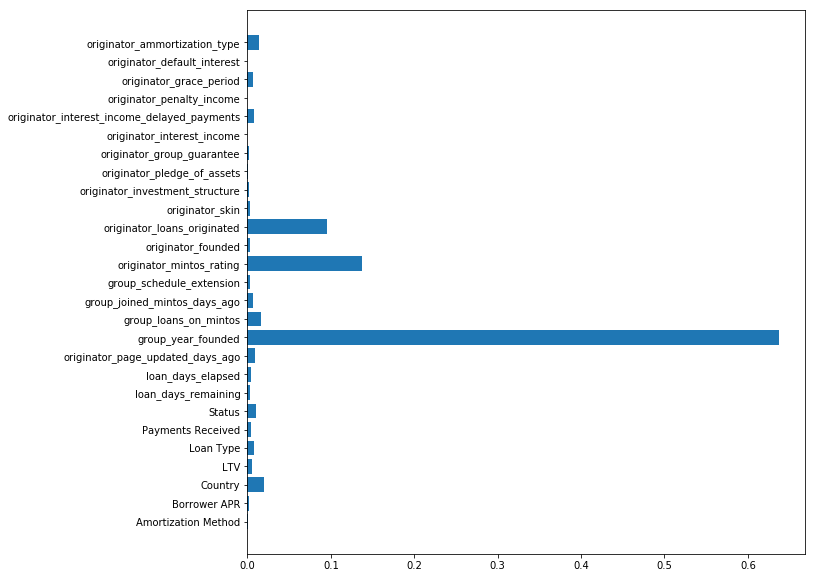

In [35]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.barh(X.columns,estimator.feature_importances_)

Using model-based analysis we see that originator group, and originator related factors are most important determinants of interest rate. The number of years originator group has been in business is the leading factor, followed by the amount of loanns originator ( which we found above is the highest linear correlate ), and Mintos own credit rating of the originator. While Mintos is not 100% transparent on how exactly they determine the rating, because of the lending structure it only makes sense that it would be a significant factor in determining the interest rate of the loan. 

I repeated regressions using Microsoft's lightgbm library, and Yandex's Catboost, with similar results. 

Opportunity

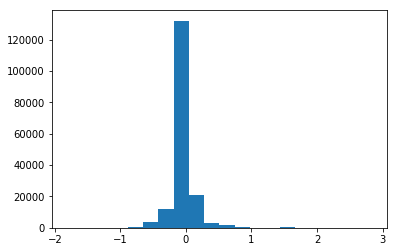

In [42]:
estimator.fit(X, Y)
yhat = estimator.predict(X)
difference = yhat - Y

plt.hist(difference,bins=20);

We see that that our model above indicates that interest rate on some loans cannot be fully explained, and some loans may be under or over priced by 1% or more. This may represent an opportunity to make a difference in the economic welfare by investment. 